# Homework Lecture 10: Optimization II

You may want to install `PuLP` for this problem set using:
* `pip install pulp`

**Unless expressly told not to, you may use functions and routines from the standard `Python` libraries. Make sure that you clearly indicate any libraries that you import. But also make sure that you understand what the function you are calling actually does.**

## Problem 1 (50 points):



Cash flow matching is a way to defease future liabilities (assuming interest rates are stationary). Consider the simple case of a startup that has the following expected cash flows:
* Month 0: -\$150 million
* Month 1: -\$100 million
* Month 2: \$200 million
* Month 3: -\$200 million
* Month 4:  \$50 million
* Month 5: \$300 million

After that, the founders believe that they will be in a continuous positive cash flow situation, but only if they survive the next five months.

Assume that at any time they can issue 3-month zero-coupon commercial paper with a 2% yield, they can borrow a month at a time from their credit line with 1% interest (per month), and they can invest cash in an interest-bearing account for one month at a time at 0.3% (per month).

How should the company finance these cash flows if they want to have no payment obligations at the end of the period? (**Hint**: This is an LP problem where you need to match the cash needs when there are negative cash flows using available cash from when there are positive cash flows combined with the various financing and investing options.)


### Solution:

We first assume that the cash flows happen at the end of each month. This means the company owes 150 million at the begining of month 1. Assume that $B_i, C_i$ is the number of dollar value of bonds and credit issued and borrowed at month $i$, $i=0,1,2...5$. Since the company want to have **no payment obligations** at the end of the period, $B_j = 0$ for $j=3,4,5$ and $C_5=0$. Our objective function is to maximize the cash we hold at the end of month 5, subject to the conditions that the company survives each month.

Clearly for the first two months where the cash flows are negative, we only need to finance what we need to pay (no need to borrow more than the negative cash flows since the interest rate is way less than the financing cost). We can formalize the problem as follows. First we write out the constraints.

\begin{aligned}
B_0+C_0 &= 150  
\\
B_1+C_1 &= 100 + 1.01 C_0
\\
B_2+C_2+200 &\geq 1.01 C_1
\\
C_3+1.003(B_2+C_2+200-1.01C_1) &\geq 200 + 1.02B_0 + 1.01C_2
\\
C_4+50 + 1.003[C_3+1.003(B_2+C_2+200-1.01C_1) - 200 - 1.02B_0 - 1.01C_2]&\geq 1.02 B_1 + 1.01 C_3
\\
1.003(\mathrm{left-right \ in\ above\ equation}) +300 &\geq 1.02B_2+ 1.01C_4 \\ 
B_i &\geq 0\ \mathrm{for}\ i=0,1,2 \\
C_i &\geq 0 \ \mathrm{for}\ i=0,1,2,3,4
\end{aligned}

Simplify the above system we get:
\begin{aligned}
B_0+C_0 &= 150  
\\
B_1+C_1- 1.01 C_0&= 100
\\
B_2+C_2-1.01 C_1+200 &\geq 0
\\
C_3+1.003B_2-0.007C_2+0.6-1.01303C_1-1.02B_0 &\geq 0
\\
C_4+50 + 1.003(1.003B_2-0.007C_2+0.6-1.01303C_1-1.02B_0) - 1.02B_1-0.007C_3&\geq 0
\\
1.003[50 + 1.003(-0.007C_2+0.6-1.01303C_1-1.02B_0) - 1.02B_1-0.007C_3] +300+(1.003^3-1.02)B_2-0.007C_4&\geq 0 \\ 
B_i &\geq 0\ \mathrm{for}\ i=0,1,2 \\
C_i &\geq 0 \ \mathrm{for}\ i=0,1,2,3,4
\end{aligned}

Since we want to maximize the money we hold at the end of month 5, the objective function is to max
$$
1.003[50 + 1.003(-0.007C_2+0.6-1.01303C_1-1.02B_0) - 1.02B_1-0.007C_3] +300+(1.003^3-1.02)B_2-0.007C_4
$$
So in fact we can remove the sixth condition and see whether the objective function is positive. 

In [1]:
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable

# Define the problem

model = LpProblem("Max_Objective", sense=LpMaximize)

# VARIABLES

B_0 = LpVariable(name='B_0', lowBound=0)
B_1 = LpVariable(name='B_1', lowBound=0)
B_2 = LpVariable(name='B_2', lowBound=0)
C_0 = LpVariable(name='C_0', lowBound=0)
C_1 = LpVariable(name='C_1', lowBound=0)
C_2 = LpVariable(name='C_2', lowBound=0)
C_3 = LpVariable(name='C_3', lowBound=0)
C_4 = LpVariable(name='C_4', lowBound=0)

# OBJECTIVE

model += 300 + 1.003 * 50 - 1.003 ** 2 * 0.007 * C_2 + 1.003 ** 2 * 0.6 - 1.003 ** 2 * 1.01303 * C_1 - 1.003 ** 2 * 1.02 * B_0 \
         - 1.003 * 1.02 * B_1 - 1.003 * 0.007 * C_3 + (1.003 ** 2 - 1.02) * B_2 - 0.007 * C_4

# ---------------------
# CONSTRAINTS
# ---------------------
model += (B_0 + C_0 == 150, 'con1')
model += (B_1 + C_1 - 1.01 * C_0 == 100, 'con2')
model += (B_2 + C_2 - 1.01 * C_1 + 200 >= 0, 'con3')
model += (C_3 + 1.003 * B_2 - 0.007 * C_2 + 0.6 - 1.01303 * C_1 - 1.02 * B_0 >= 0, 'con4')
model += (
    C_4 + 50 + 1.003 * (1.003 * B_2 - 0.007 * C_2 + 0.6 - 1.01303 * C_1 - 1.02 * B_0) - 1.02 * B_1 - 0.007 * C_3 >= 0,
    'con5')

status = model.solve()

# And print the results
print(f"status: {model.status}, {LpStatus[model.status]}")

print(f"objective: {model.objective.value()}")

for var in model.variables():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")


status: 1, Optimal
objective: 92.03837751753
B_0: 150.0
B_1: 100.0
B_2: 151.94417
C_0: 0.0
C_1: 0.0
C_2: 0.0
C_3: 0.0
C_4: 52.0
con1: 0.0
con2: 0.0
con3: 351.94417
con4: 2.510000001620938e-06
con5: 2.5175299924740102e-06


**Conclusion**

We can see that the program ends successfully and all the constraints are satisfied. In conclusion, in month 0 (at the begining of month 1) and in the end of month 1, we finance the cash flow purely with bonds. In the end of month 2, we issue bonds worth 151.94 (maybe 152 in reality) million dollars, and invest cash left in the interest account. In the end of month 4, we borrow from the credit line for 52 million dollars. In such a way, the company will survive the next 5 months while the cash left in the end of month 5 is maximized.

## Problem 2 (50 points):

In class there was a (very) rough visualizations of the implied volatility surface using call options on Apple.

In this problem, we are interested in developing an improved 3-d representation of the vol surface. 

A. Construct the vol surface for Apple calls with a couple of improvements: (**10 points each**)
* Instead of plotting against the raw strike price, plot against the log-strike.
* Instead of plotting against the date, plot against the **time** to expiry.

B. Construct the vol surface for Apple puts also. (**5 points**)

C. Generate a smooth vol surface for either puts or calls (or a combination?). (Hint, you may want to smooth the volatilities before plotting). (**25 points**)

**You do not need to use the same 3-d plotting function used in the lecture notes.**

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

### A 

In [3]:
def get_options(ticker):
    today = datetime.date.today()
    optionTicker= yf.Ticker(ticker)
    callOptions = pd.DataFrame()
    putOptions = pd.DataFrame()

    for expry in optionTicker.options:
        try:
            exp = datetime.datetime.strptime(expry, '%Y-%m-%d').date()
            t = (exp - today).days/365
            if t == 0:
                continue
            opt = optionTicker.option_chain(expry)
            temp_call = pd.DataFrame(opt.calls)
            temp_put = pd.DataFrame(opt.puts)
            temp_call['expry'] = expry # add column for expiry date
            temp_call['timeToMaturity'] = t
            temp_put['expry'] = expry # add column for expiry date
            temp_put['timeToMaturity'] = t
            callOptions = callOptions.append(temp_call)
            putOptions = putOptions.append(temp_put) 
        except ValueError: 
            pass
    callOptions = callOptions.reset_index()
    putOptions = putOptions.reset_index()
    return(callOptions,putOptions)

calls, puts = get_options('AAPL')
calls = calls.drop(columns = ['index','contractSymbol', 'currency', 'change', 'percentChange', 'contractSize', 'lastTradeDate'])
calls = calls[calls['openInterest']>0]
calls.reset_index(drop=True, inplace=True)
puts = puts.drop(columns = ['index','contractSymbol', 'currency', 'change', 'percentChange', 'contractSize', 'lastTradeDate'])
puts  = puts[puts['openInterest']>0]
puts.reset_index(drop=True, inplace=True)
calls

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expry,timeToMaturity
0,5.0,173.00,170.90,172.20,1.0,655,0.500005,True,2024-04-19,0.019178
1,10.0,163.00,165.60,167.30,20.0,11,10.769535,True,2024-04-19,0.019178
2,15.0,155.95,160.85,162.20,1.0,2,8.820317,True,2024-04-19,0.019178
3,30.0,142.65,146.05,147.15,30.0,45,4.453129,True,2024-04-19,0.019178
4,40.0,146.28,139.60,140.20,1.0,1,7.398438,True,2024-04-19,0.019178
...,...,...,...,...,...,...,...,...,...,...
1002,310.0,4.45,2.85,4.55,24.0,49,0.264259,False,2026-12-18,2.684932
1003,320.0,3.80,1.96,4.90,2.0,28,0.279548,False,2026-12-18,2.684932
1004,330.0,5.25,2.48,4.75,6.0,11,0.286720,False,2026-12-18,2.684932
1005,340.0,2.88,2.35,2.98,11.0,34,0.264351,False,2026-12-18,2.684932


In [4]:
# linear interpolation
def plot_surf(X,Y,Z,title):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),100),np.linspace(min(Y),max(Y),100))
    # griddata interpolates linearly
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY), method='linear')
    ZZ = np.nan_to_num(ZZ,0.1)
    ax.plot_surface(np.log(XX), YY, ZZ, cmap=cm.jet)
    ax.view_init(elev=10, azim=45)
    ax.set_xlabel('log-strike')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)
    plt.show()

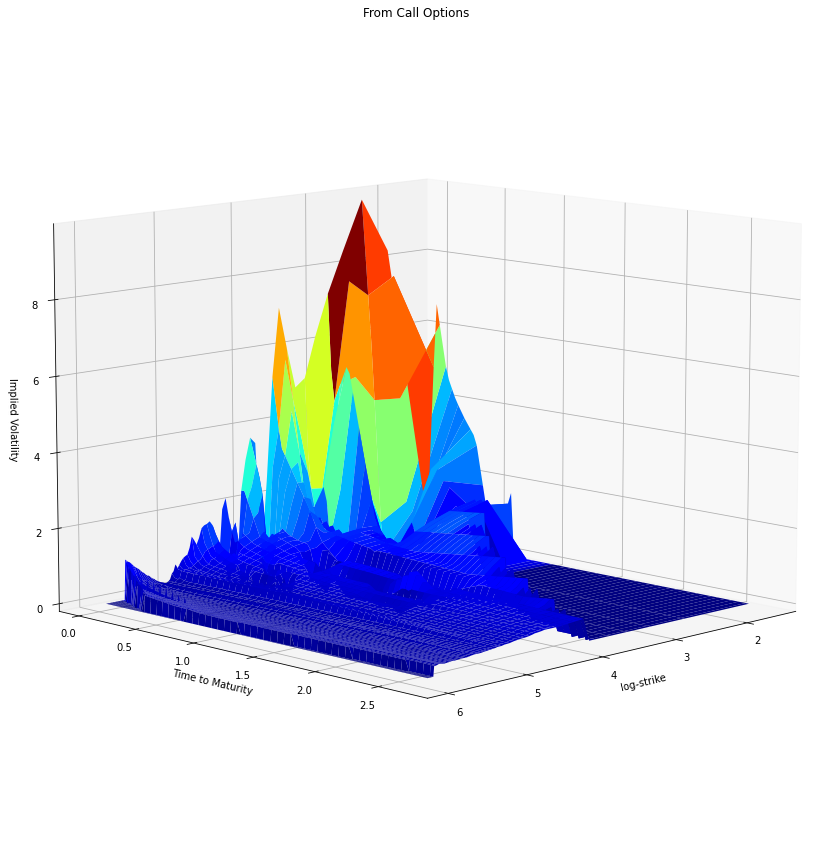

In [5]:
plot_surf(calls['strike'],calls['timeToMaturity'],calls['impliedVolatility'],'From Call Options')

### B 

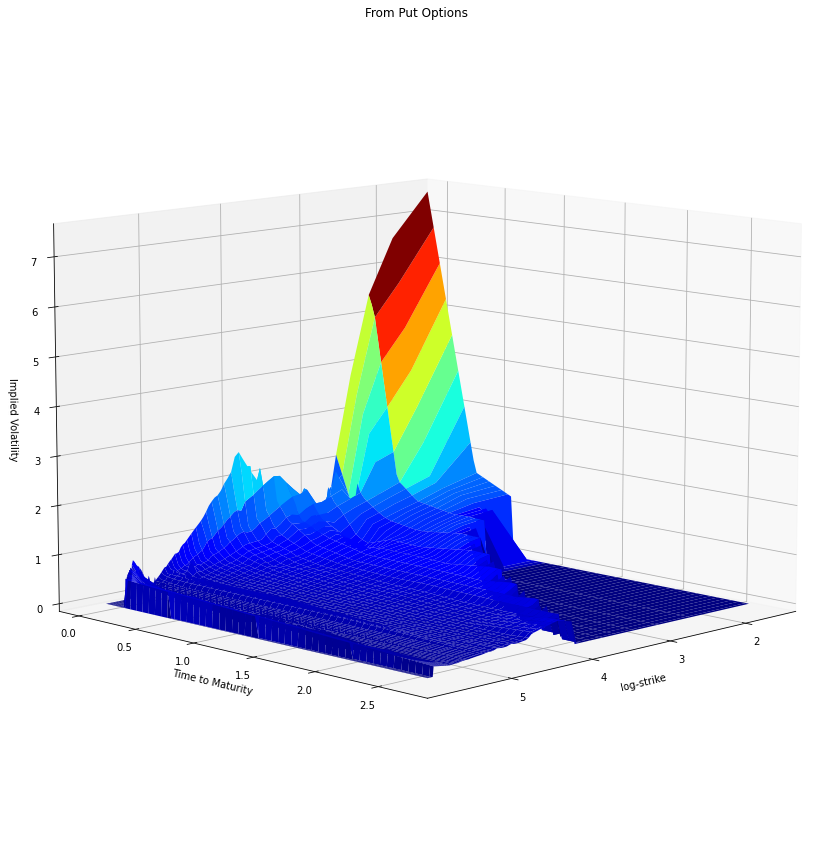

In [6]:
plot_surf(puts['strike'],puts['timeToMaturity'],puts['impliedVolatility'], 'From Put Options')

### C

First let's try Radial Basis Functions. The basis of this method lies in constructing an interpolant as a weighted sum of radial basis functions centered at given data points. This approach ensures that the function exactly interpolates the data at given points while smoothly estimating values at other points.

In [7]:
from scipy.interpolate import interp2d, Rbf

In [8]:
def plot_surf_rbf(X,Y,Z,title):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),100),np.linspace(min(Y),max(Y),100))
    rbf = Rbf(X, Y, Z, function='linear') 
    ZZ = rbf(XX,YY)
    ZZ[ZZ<0] = 0.1
    ax.plot_surface(np.log(XX), YY, ZZ, cmap=cm.jet)
    ax.view_init(elev=10, azim=45)
    ax.set_xlabel('log-strike')
    ax.set_ylabel('Time to Maturity')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)
    plt.show()

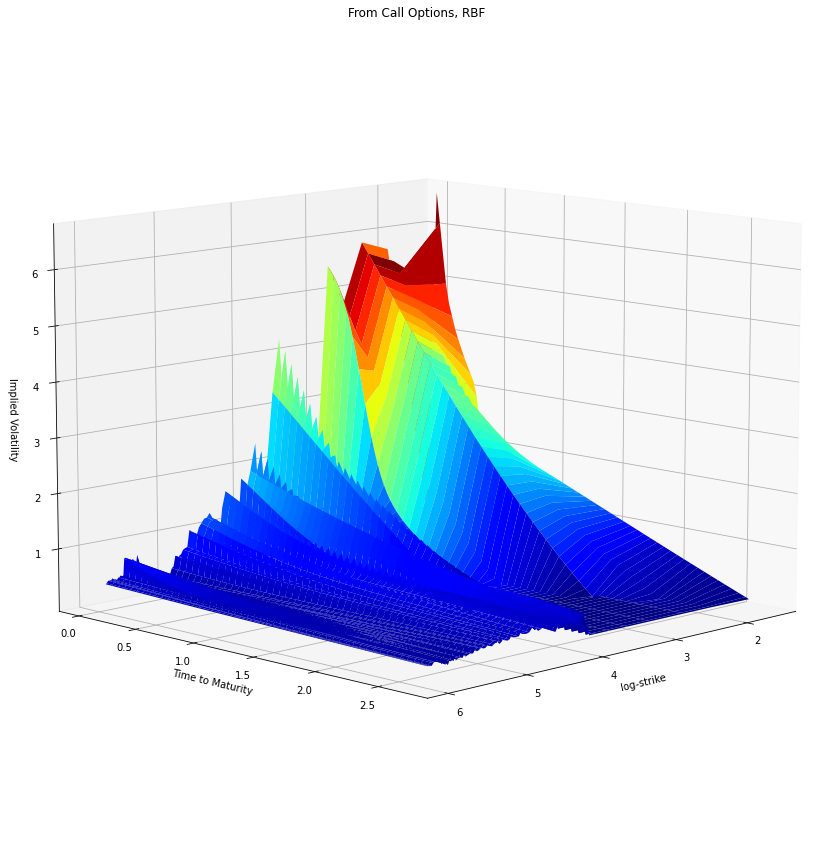

In [9]:
plot_surf_rbf(calls['strike'],calls['timeToMaturity'],calls['impliedVolatility'],'From Call Options, RBF')

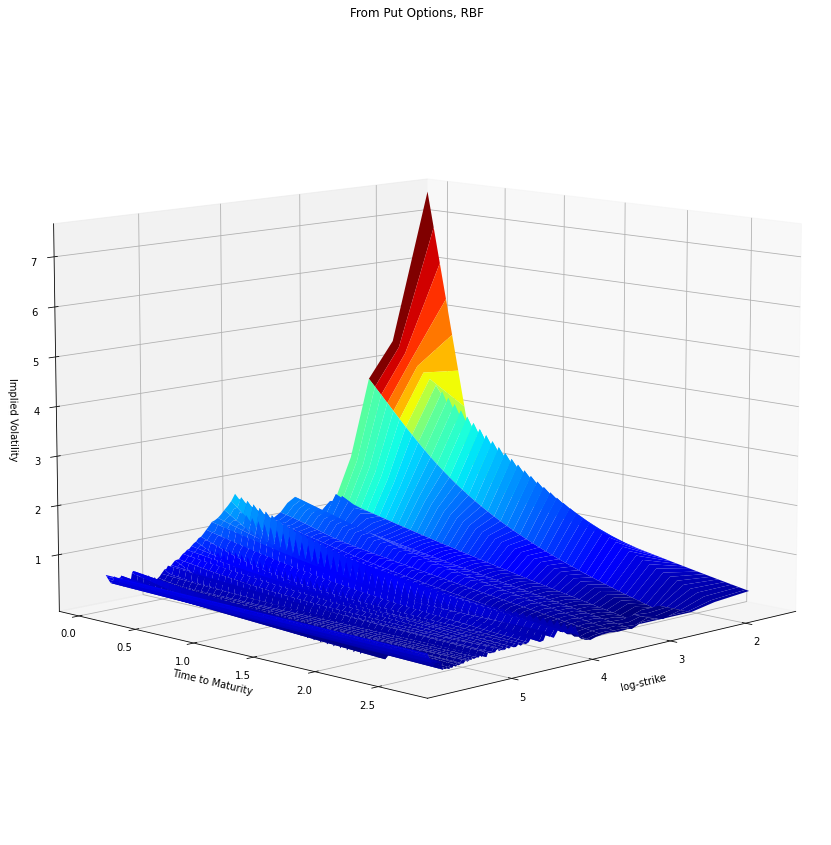

In [10]:
plot_surf_rbf(puts['strike'],puts['timeToMaturity'],puts['impliedVolatility'], 'From Put Options, RBF')

We may also try some parametric methods to fit the model against the surface, like SVI (stochastic volatility inspired) or SSVI. Similar work has been done in another course called Advanced Equity Derivatives. Here we just show the results from there. The project calibrates SSVI against IV surface of SPX.

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import cm
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize, minimize_scalar

In [12]:
r = 0.0505 # 1Y treasury rate on 20240405 as risk free rate
S = 5204.34

In [13]:
def get_dividend(call_price,put_price,S,K,T):# takes ATM (closest strike to spot) puts and calls
    return -np.log((call_price - put_price + K*np.exp(-r*T))/S)/T

def get_fwd(S,r,q,T):
    return S*np.exp((r-q)*T)

def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def get_implied_vol(S, K, T, r, market_price, option_type="call"):
    def error(sigma):
        return (black_scholes(S, K, T, r, sigma, option_type) - market_price)**2
    res = minimize_scalar(error, method='bounded', bounds=[0.01, 5])
    return res.x

def svi_raw(parameters, k, g_func=False):
    """ SVI raw parametrization for total implied variance
    k: log forward moneyness for which total variance is evaluated
    
    :parameter a:       vertical translation of the smile
    :parameter b:       tightens the smile
    :parameter m:       translates the smile to the right
    :parameter rho:     counterclockwise rotation of the smile
    :parameter sigma:   controls the ATM curvature of the smile
    """
    a, b, m, rho, sigma = parameters
    term1 = (k - m)**2 + sigma**2
    w = a + b * (rho * (k - m) + np.sqrt(term1))
    if g_func:
        w1 = b * (rho + (k - m) / (np.sqrt(term1)))
        w2 = b * sigma**2 / term1**1.5
        g = (1 - 0.5 * (k * w1 / w))**2 - (0.25 * w1**2) * ((1 / w) + 0.25) + 0.5 * w2
        return w, g
    return w

def svi_natural(parameters, k, g_func=False):
    """ SVI natural parametrization for total implied variance
    k: log forward moneyness for which total variance is evaluated
    
    :parameter delta:
    :parameter mu:
    :parameter rho:
    :parameter omega:
    :parameter zeta:
    """
    delta, mu, rho, omega, zeta = parameters
    term1 = 1 + zeta * rho * (k - mu)
    term2 = (zeta * (k - mu) + rho)**2 + (1 - rho**2)
    w = delta + 0.5 * omega * (term1 + np.sqrt(term2))
    if g_func:
        w1 = 0.5 * omega * (zeta * rho + (zeta**2 * (k - mu) + zeta * rho) / np.sqrt(term2))
        w2 = (omega * zeta**2 * (1 - rho**2)) / (2 * term2**1.5)
        g = (1 - 0.5 * (k * w1 / w))**2 - (0.25 * w1**2) * ((1 / w) + 0.25) + 0.5 * w2
        return w, g
    return w

def svi_jump_wings(parameters, k, t, g_func=False):
    """ SVI Jump-Wings parametrization for total implied variance
    k: log forward moneyness for which total variance is evaluated
    t: the time slice
    
    :parameter v:       The ATM variance
    :parameter psi:     The ATM skew
    :parameter p:       The slope of the left (put) wing
    :parameter c:       The slope of the right (call) wing
    :parameter v_tilde: The minimum implied variance
    """
    raw_parameters = convert_jumpwing_to_raw(parameters, t)
    res = svi_raw(raw_parameters, k, g_func)
    if g_func:
        w, g = res
        return w, g
    w = res
    return w


def convert_raw_to_jumpwing(parameters_raw, t):
    """ 
    Converts SVI raw parameters to SVI Jump-Wings parameters for a given time slice t
    
    """
    a, b, m, rho, sigma = parameters_raw
    w = a + b * (-rho * m + np.sqrt(m**2 + sigma**2))
    v = w / t
    psi = 1 / np.sqrt(w) * b / 2 * (-m / np.sqrt(m**2 + sigma**2) + rho)
    p = 1 / np.sqrt(w) * b * (1 - rho)
    c = 1 / np.sqrt(w) * b * (1 + rho)
    v_tilde = 1 / t * (a + b * sigma * np.sqrt(1 - rho**2))
    parameters_jw = np.array([v, psi, p, c, v_tilde])
    return parameters_jw
    

def convert_jumpwing_to_raw(parameters_jw, t):
    """ 
    Converts SVI Jump-Wings parameters to SVI raw parameters  for a given time slice t
    
    """
    parameters_jw = np.array(parameters_jw)
    parameters_jw = parameters_jw.reshape(-1, 1) if parameters_jw.ndim==1 else parameters_jw
    v, psi, p, c, v_tilde = parameters_jw
    w = v * t
    b = np.sqrt(w) / 2 * (c + p)
    rho = 1 - p * np.sqrt(w) / b
    beta = rho - 2 * psi * np.sqrt(w) / b
    alpha = np.sign(beta) * np.sqrt(1 / beta**2 - 1)
    m = (v - v_tilde) * t / (b * (-rho + np.sign(alpha) * np.sqrt(1 + alpha**2) - alpha * np.sqrt(1 - rho**2)))
    sigma = alpha * m
    temp = (v_tilde * t - w) / b / (np.sqrt(1 - rho**2) - 1)
    sigma[m==0] = temp[m==0]
    a = v_tilde * t - b * sigma * np.sqrt(1 - rho**2)
    sigma[sigma < 0] = 0
    parameters_raw = np.array([a, b, m, rho, sigma])
    return parameters_raw


def repick_jw_parameters(parameters):
    """ 
    modifies the call wing (c) and the minimum variance (v_tilde) of SVI-jump-wings parameters
    to get a smile guaranteed to be free of butterfly arbitrage
    
    """
    p1, p2, p3 = parameters[:3]
    p4 = p3 + 2 * p2
    p5 = p1 * 4 * p3 * p4 / (p3 + p4)**2
    parameters = np.array([p1, p2, p3, p4, p5])
    return parameters

def butterfly_arbitrage_removal(jw_params, k, t, mkt_vols, standard_k, vegas=None):
    """ 
    Removes butterfly arbitrage from a smile in the jump-wings parametrization space by
    repicking the right (call) slope and the minimum implied variance parameters
    to get a smile that is free of butterfly arbitrage and is as close as possible to
    the original smile
    
    """
    if vegas is None: vegas = np.ones(len(k))
    repicked_jw_params = repick_jw_parameters(jw_params) # guaranteed to be arbitrage free
    x0 = repicked_jw_params[-2:]
    bnds = ( tuple(sorted([jw_params[-2:][0], repicked_jw_params[-2:][0]])),
    tuple(sorted([jw_params[-2:][1], repicked_jw_params[-2:][1]])) )
    
    def obj_func(x0, params):
        params = np.append(params[:3], x0)
        svi_vols = np.sqrt(svi_jump_wings(params, k, t) / t)
        diff = np.linalg.norm(vegas * (mkt_vols - svi_vols) )
        return diff
    
    con = {'type': 'ineq', 'fun': 
           lambda x: svi_jump_wings(np.append(jw_params[:3], x), standard_k, t, g_func=True)[1] - 1e-8}
    cons = [con,]
    res = minimize(obj_func, x0, args=(jw_params), method='SLSQP', constraints=cons, bounds=bnds)
    jw_params = np.append(jw_params[:3], res.x)
    return jw_params


def calibrate_svi_raw(k, t, mkt_vols, standard_k, vegas=None, init_guess=None):  
    """ 
    finds optimal arbitrage free raw SVI parameters that fit martet prices
    
    """
    # objective function for calibration
    def obj_func(x0):
        svi_vols = np.sqrt(svi_raw(x0, k) / t)
        diff = np.linalg.norm(vegas * (mkt_vols - svi_vols))
        return diff
    
    if vegas is None: vegas = np.ones(len(k))
    bnds = [(1e-5, t * max(mkt_vols)**2), (1e-3, 0.5), (2 * min(k), 2 * max(k)), (-1, 1), (1e-2, 1)]
    con = {'type': 'ineq', 'fun': lambda x: svi_raw(x, standard_k, g_func=True)[1]-1e-8}
    cons = [con,]
    if init_guess is None:
        # sample initial guess
        params_arr = []
        diffs = []
        N = 30
        for j in range(N):
            x0 = [0.5 * np.sqrt(min(mkt_vols)/t)] + [np.random.uniform(bnd[0], bnd[1]) for bnd in bnds[1:]]
            res = minimize(obj_func, x0, method='SLSQP', bounds=bnds, constraints=cons)
            params_arr.append(res.x)
            diffs.append(res.fun)
        raw_params = params_arr[np.argmin(diffs)]
        res = minimize(obj_func, raw_params, method='SLSQP', bounds=bnds, constraints=cons)
        raw_params = res.x
    else:
        res = minimize(obj_func, init_guess, method='SLSQP', bounds=bnds, constraints=cons)
        raw_params = res.x
    return raw_params

def power_law(parameters, theta):
    """
    Power law parametrization of phi in the SSVI function
    
    """
    gamma = 0.5
    rho, eta = parameters
    phi = eta / ((theta**gamma) * (1.0 + theta)**(1.0 - gamma))
    return phi

def calibrate_ssvi(tenors, thetas, k_data, vol_data):
    """ 
    finds optimal arbitrage free SSVI parameters that fit martet prices
    corresponds to natural SVI with {0, 0, ρ, θt, ϕ(θt)}. 
    This fits the whole surface, not a time slice
    """
    # params are rho and eta
    def ssvi_obj_func(params):
        rho = params[0]
        diff = 0
        for i in range(len(tenors)):
            theta = thetas[i]
            phi = power_law(params, theta)
            ssvi_param = [0, 0, rho, theta, phi]
            k = k_data[i]
            mkt_vols = vol_data[i]
            ssvi_vols = svi_natural(ssvi_param, k)
            diff += np.linalg.norm(mkt_vols - ssvi_vols)
        return diff
    
    cons = {'type': 'ineq', 'fun': lambda x: 2 - x[1] * (1 + abs(x[0]))}
    bnds = ((-1,1), (0., None))
    params_arr = []
    diffs = []
    N = 30
    for j in range(N):
        x0 = [np.random.uniform(-1, 1), np.random.uniform(0, 1)]
        res = minimize(ssvi_obj_func, x0, constraints=cons, method='trust-constr', bounds=bnds)
        params_arr.append(res.x)
        diffs.append(res.fun)
    best_guess = params_arr[np.argmin(diffs)]
    res = minimize(ssvi_obj_func, best_guess, constraints=cons, method='trust-constr', bounds=bnds)
    return res.x

In [14]:
import warnings
warnings.filterwarnings("ignore")

standard_k = np.linspace(-0.3, 0.3, 32)
q = get_dividend(83.7,69.2,S,5200,25/365)

# function that fit raw SVI params for a certain tenor
def fit_raw_SVI(t,Ks,mkt_prices,types): # Ks are strikes
    mrk_IVs = np.array([get_implied_vol(S, Ks[i], t, r, mkt_prices[i], option_type=types[i]) for i in range(len(Ks))])
    fwd_price = get_fwd(S,r,q,t)
    ks = np.array([np.log(Ks[i]/fwd_price) for i in range(len(Ks))])
    raw_params = calibrate_svi_raw(ks,t,mrk_IVs,standard_k)
    g = svi_raw(raw_params, standard_k, g_func=True)[1]
    if np.any(g < 0):
        jw_params = convert_raw_to_jumpwing(raw_params, t)
        jw_params = butterfly_arbitrage_removal(jw_params, ks, t, mrk_IVs, standard_k)
        raw_params = convert_jumpwing_to_raw(jw_params, t).squeeze()
        
    iv_pred = np.sqrt(svi_raw(raw_params, ks) / t)
    g_opt = svi_raw(raw_params, standard_k, g_func=True)[1]
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(ks, iv_pred, c='red', label='Raw SVI')
    ax1.scatter(ks, mrk_IVs, color='blue', label='market')
    ax1.set_ylabel('Implied Volatility')
    ax1.legend(loc='upper right')
    ax2.plot(standard_k, g_opt, c='red')
    ax2.axhline(y=0, color='k')
    ax2.set_ylabel('g-function (g(k)')
    ax2.set_xlabel('log-moneyness')
    fig.suptitle('Tenor=' + str(round(t, 3)))
    plt.show()
    return raw_params, ks, mrk_IVs

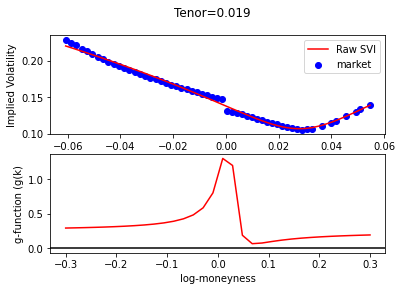

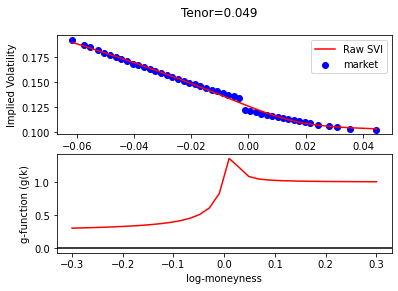

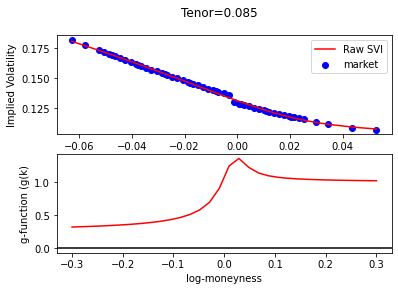

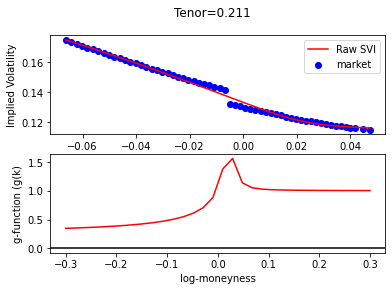

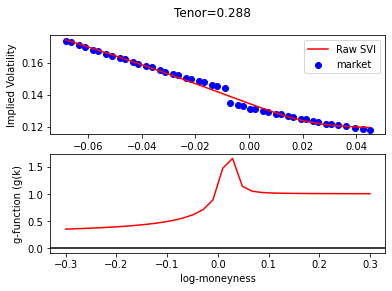

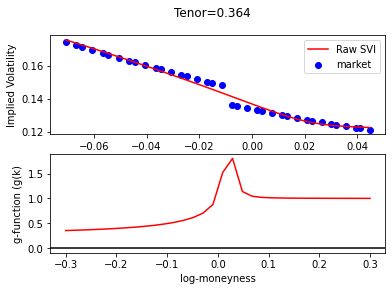

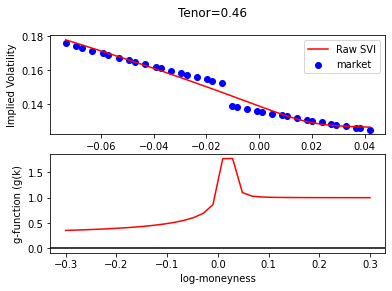

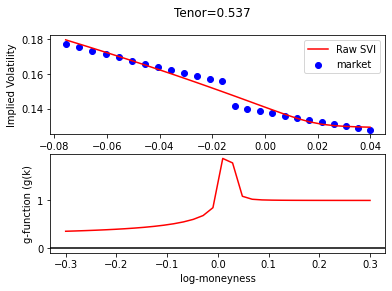

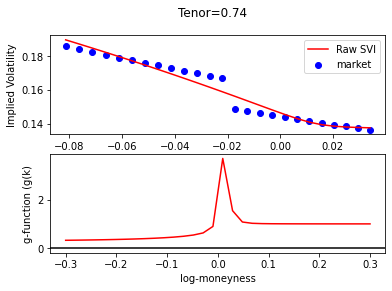

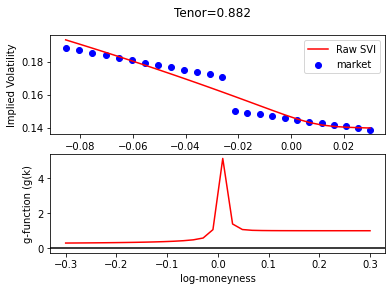

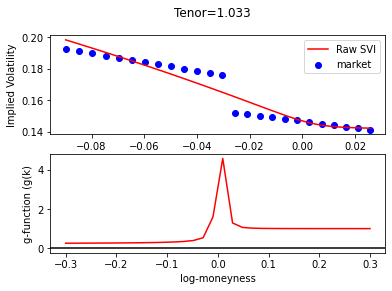

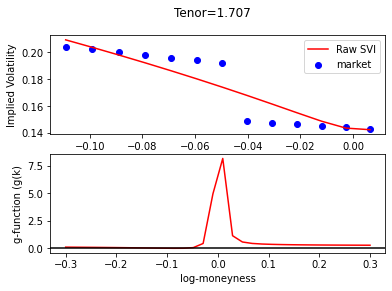

In [15]:
today = datetime(2024, 4, 5)

exp_dates = [('2024-04-12','Fri Apr 12 2024'),('2024-04-23','Tue Apr 23 2024'),('2024-05-06','Mon May 06 2024'),
             ('2024-06-21','Fri Jun 21 2024'),('2024-07-19','Fri Jul 19 2024'),('2024-08-16','Fri Aug 16 2024'),
             ('2024-09-20','Fri Sep 20 2024'),('2024-10-18','Fri Oct 18 2024'),('2024-12-31','Tue Dec 31 2024'),
             ('2025-02-21','Fri Feb 21 2025'),('2025-04-17','Thu Apr 17 2025'),('2025-12-19','Fri Dec 19 2025')]

# #================================================ SVI Raw ============================================#
RAW_SVI_param_list = []
# Some preparation for SSVI
SSVI_tenors = []
SSVI_k_data = []
SSVI_mkt_vol_data = []

for date, col_name in exp_dates:
    sheet_name = date[:-3]
    t = (datetime.strptime(date, '%Y-%m-%d') - today).days / 365
    opt_prs_data = pd.read_excel('opt_data.xlsx',sheet_name = sheet_name)
    used_df = opt_prs_data[opt_prs_data['Expiration Date'] == col_name][['Bid Call','Ask Call','Strike','Bid Put','Ask Put']]
    used_df = used_df[(used_df['Strike'] >= 4900) & (used_df['Strike'] <= 5500)]
    while len(used_df) > 60:
        used_df = used_df.iloc[::2]
    used_df = used_df.reset_index(drop=True)
    used_df['mid call'] = (used_df['Bid Call'] + used_df['Ask Call'])/2
    used_df['mid put'] = (used_df['Bid Put'] + used_df['Ask Put'])/2
    OTM_puts = used_df[used_df['Strike']<S]['mid put']
    OTM_calls = used_df[used_df['Strike']>S]['mid call']
    Ks = list(used_df['Strike'].values)
    mkt_prices = list(OTM_puts.values) + list(OTM_calls.values)
    types = ['put']*len(OTM_puts)+['call']*len(OTM_calls) 
    params, ks, IVs = fit_raw_SVI(t,Ks,mkt_prices,types)
    RAW_SVI_param_list.append(params)
    # data preparation for SSVI
    SSVI_tenors.append(t)
    SSVI_k_data.append(ks)
    SSVI_mkt_vol_data.append(IVs)

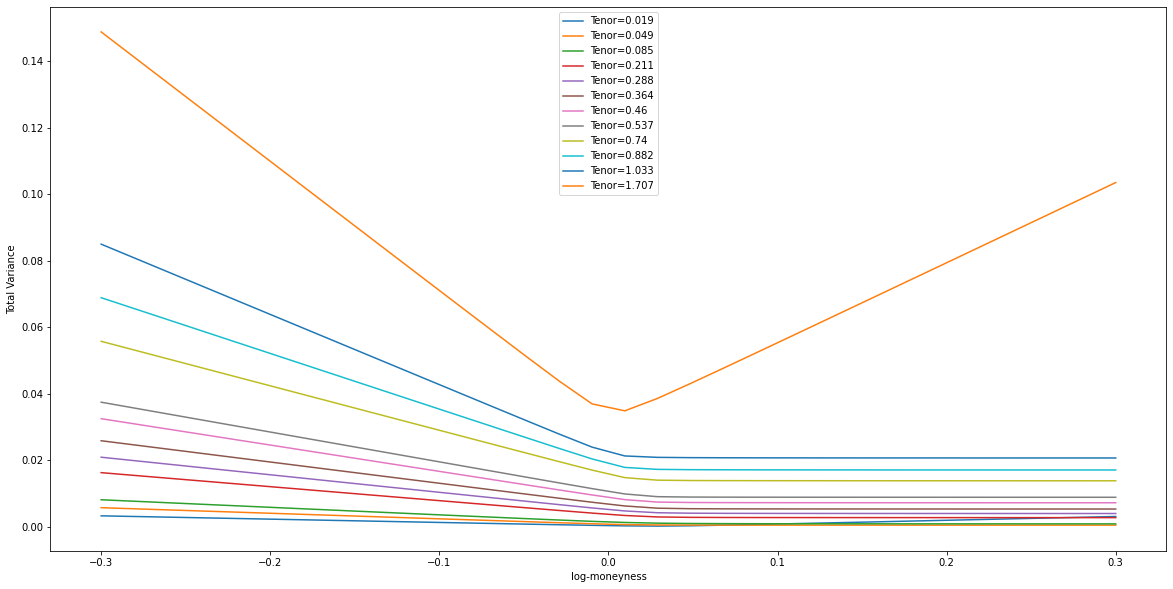

In [16]:
# check calender spread arbitrage opportunities
plt.figure(figsize=(20,10))
for i in range(len(exp_dates)):
    date = exp_dates[i][0]
    t = (datetime.strptime(date, '%Y-%m-%d') - today).days / 365
    total_variance = svi_raw(RAW_SVI_param_list[i], standard_k)
    plt.plot(standard_k, total_variance,label='Tenor=' + str(round(t, 3)))
plt.legend()
plt.xlabel('log-moneyness')
plt.ylabel('Total Variance')
plt.show()

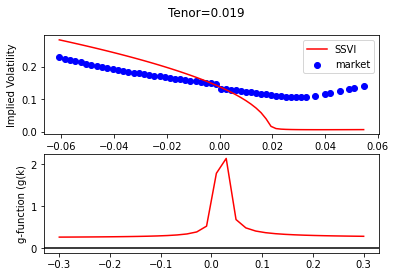

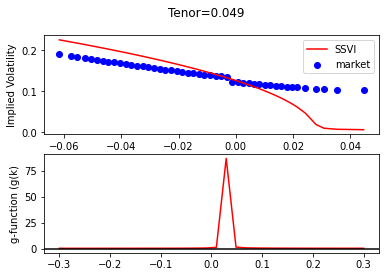

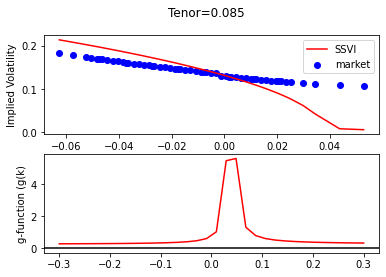

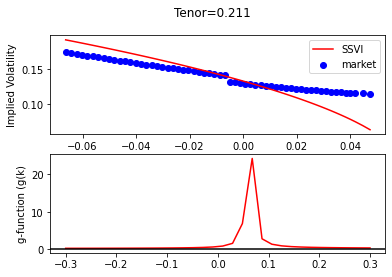

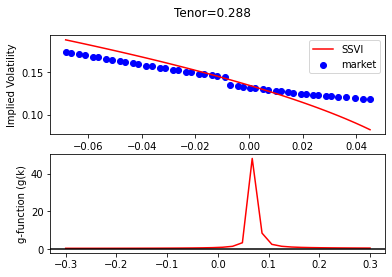

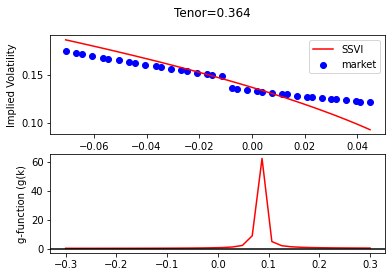

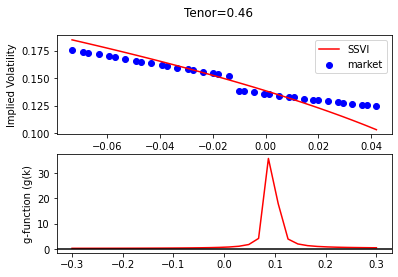

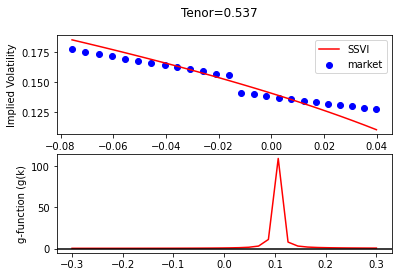

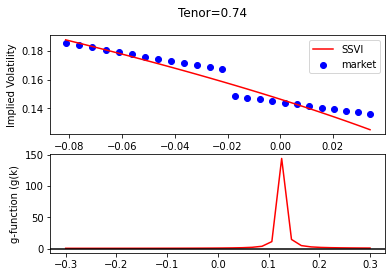

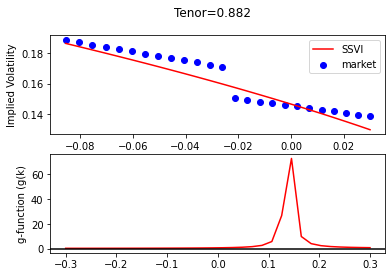

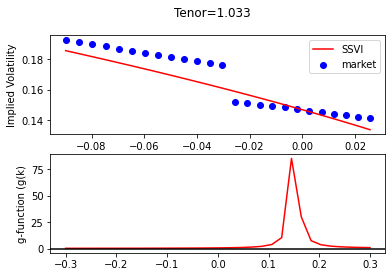

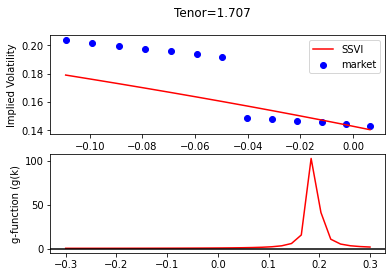

In [17]:
#============================================ Surface SVI ===========================================#
thetas = np.array([svi_raw(RAW_SVI_param_list[i], 0) for i in range(len(RAW_SVI_param_list))])
SSVI_k_data = np.array(SSVI_k_data)
SSVI_mkt_vol_data = np.array(SSVI_mkt_vol_data)
opt_params = calibrate_ssvi(SSVI_tenors, thetas, SSVI_k_data, SSVI_mkt_vol_data)
rho = opt_params[0]
SSVI_ratural_params_list = []
# plot the volatlity fit and g-function
for i in range(len(SSVI_tenors)):
    k, t, mkt_vols = SSVI_k_data[i], SSVI_tenors[i], SSVI_mkt_vol_data[i]
    theta = thetas[i]
    phi = power_law(opt_params, theta)
    ssvi_natural_param = [0., 0., rho, theta, phi]
    SSVI_ratural_params_list.append(ssvi_natural_param)
    IV_ssvi = np.sqrt(svi_natural(ssvi_natural_param, k) / t)
    g = svi_natural(ssvi_natural_param, standard_k, g_func=True)[1]
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(k, IV_ssvi, c='red', label='SSVI')
    ax1.scatter(k, mkt_vols, color='blue', label='market')
    ax1.set_ylabel('Implied Volatility')
    ax1.legend(loc='upper right')    
    ax2.plot(standard_k, g, color='red')
    ax2.axhline(y=0, color='k')
    ax2.set_ylabel('g-function (g(k)')
    fig.suptitle('Tenor=' + str(round(t, 3)))
    plt.show()

In [18]:
# plot SSVI volatility surface
ssvi_vol_surface = np.array([np.sqrt(svi_natural(SSVI_ratural_params_list[i], standard_k) / SSVI_tenors[i]) 
                             for i in range(len(SSVI_tenors))])

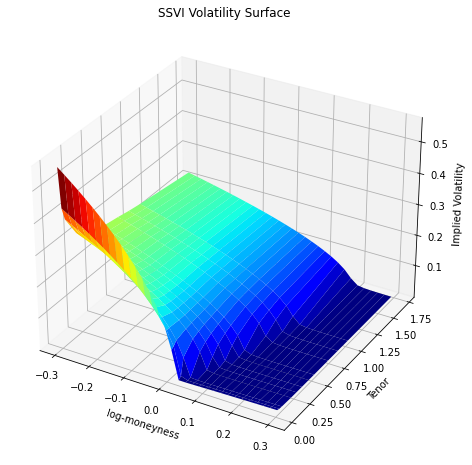

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(standard_k, SSVI_tenors)
ax.plot_surface(X, Y, ssvi_vol_surface, cmap=cm.jet)
ax.set_xlabel('log-moneyness')
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.set_title('SSVI Volatility Surface')
plt.show()

In [20]:
def interpolate_SSVI(tenors, thetas, IV_surface,kind='linear'):
    N = len(tenors)
    inter_nums = [3*i for i in range(1,N)]  # interpolate less for near, more for further tenor
    interpolated_IV_surface = IV_surface[0]
    interpolated_tenor = np.array([tenors[0]])
    f = interpolate.interp1d(SSVI_tenors, thetas,kind=kind)
    for i in range(N-1):
        interpolated_t = np.linspace(tenors[i],tenors[i+1],inter_nums[i])
        interpolated_tenor = np.append(interpolated_tenor,interpolated_t[1:])
        interpolated_t = interpolated_t[1:-1]
        inter_thetas = f(interpolated_t)
        fwd_1 = get_fwd(S,r,q,tenors[i])
        fwd_2 = get_fwd(S,r,q,tenors[i+1])
        IV_store = []
        for j in range(len(standard_k)):
            K_1 = fwd_1 * np.exp(standard_k[j])
            K_2 = fwd_2 * np.exp(standard_k[j])
            C_1 = black_scholes(S, K_1, tenors[i], r, IV_surface[i,j]) * np.exp(r*tenors[i])
            C_2 = black_scholes(S, K_2, tenors[i+1], r, IV_surface[i+1,j]) * np.exp(r*tenors[i+1])
            K_t = get_fwd(S,r,q,interpolated_t) * np.exp(standard_k[j])
            alpha_t = (np.sqrt(thetas[i+1]) - np.sqrt(inter_thetas)) / (np.sqrt(thetas[i+1]) - np.sqrt(thetas[i]))
            C_t = (alpha_t * C_1/K_1 + (1-alpha_t)*C_2/K_2) * K_t * np.exp(-r * interpolated_t)
            interpolated_IVs = [get_implied_vol(S, K_t[p], interpolated_t[p], r, C_t[p]) for p in range(len(C_t))]
            IV_store.append(interpolated_IVs)
        IV_store = np.array(IV_store).T
        interpolated_IV_surface = np.vstack((interpolated_IV_surface, IV_store))
        interpolated_IV_surface = np.vstack((interpolated_IV_surface, IV_surface[i+1]))
    return interpolated_tenor, interpolated_IV_surface

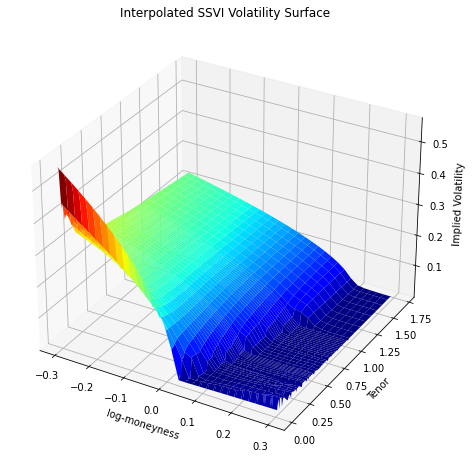

In [21]:
interpolated_tenor, interpolated_SSVI = interpolate_SSVI(SSVI_tenors, thetas, ssvi_vol_surface)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(standard_k, interpolated_tenor)
ax.plot_surface(X, Y, interpolated_SSVI, cmap=cm.jet)
ax.set_xlabel('log-moneyness')
ax.set_ylabel('Tenor')
ax.set_zlabel('Implied Volatility')
ax.set_title('Interpolated SSVI Volatility Surface')
plt.show()